In [5]:
import numpy as np
import pandas as pd
deliveries=pd.read_csv("./deliveries.csv")
matches=pd.read_csv("./matches.csv")

In [6]:
teams=['Mumbai Indians', 'Kolkata Knight Riders','Rajasthan Royals', 'Chennai Super Kings','Sunrisers Hyderabad','Delhi Capitals', 'Punjab Kings','Lucknow Super Giants', 'Gujarat Titans','Royal Challengers Bengaluru']

In [7]:
matches['team1']=matches['team1'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')
matches['team1']=matches['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
matches['team1']=matches['team1'].str.replace('Kings XI Punjab','Punjab Kings')
matches['team1']=matches['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
matches['team2']=matches['team2'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')
matches['team2']=matches['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
matches['team2']=matches['team2'].str.replace('Kings XI Punjab','Punjab Kings')
matches['team2']=matches['team2'].str.replace('Delhi Daredevils','Delhi Capitals')
matches['winner']=matches['winner'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')
matches['winner']=matches['winner'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
matches['winner']=matches['winner'].str.replace('Kings XI Punjab','Punjab Kings')
matches['winner']=matches['winner'].str.replace('Delhi Daredevils','Delhi Capitals')
matches=matches[matches['team1'].isin(teams)]
matches=matches[matches['team2'].isin(teams)]
matches=matches[matches['method']!='D/L']
matches= matches[['id','city','winner','target_overs']]
delivery_df=matches.merge(deliveries,left_on='id',right_on='match_id')
delivery_df=delivery_df[delivery_df["inning"]==1]

In [8]:
delivery_df['total_runs_scored']=delivery_df.groupby('match_id')['total_runs'].cumsum()
delivery_df['balls_left']=delivery_df['target_overs']*6-delivery_df['over']*6-delivery_df['ball']
# delivery_df = delivery_df.drop(['id'], axis=1)

In [9]:
delivery_df['CRR']=(delivery_df['total_runs_scored']*6)/(delivery_df['target_overs']*6-delivery_df['balls_left'])
delivery_df['fow']=delivery_df.groupby('match_id')['is_wicket'].cumsum()
delivery_df['wickets_left']=10-delivery_df['fow']
delivery_df=delivery_df.drop(['fow'],axis=1)

In [10]:
def func(row):
    return 1 if row['batting_team']==row['winner'] else 0
delivery_df['result']=delivery_df.apply(func,axis=1)

In [12]:
final_df=delivery_df[['batting_team','bowling_team','city','total_runs_scored','balls_left','wickets_left','CRR','result']]
final_df=final_df.sample(final_df.shape[0])

In [14]:
final_df.dropna(inplace=True)
final_df=final_df[final_df['balls_left']>=0]


In [15]:
final_df.shape

(111338, 8)

In [16]:
from sklearn.model_selection import train_test_split
X=final_df.iloc[:,:-1]
y=final_df.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1) 

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf',OneHotEncoder(drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [45]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [46]:
pipe.fit(X_train,y_train)

c:\Users\ABISHEK\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first'),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', RandomForestClassifier())])

In [47]:
y_pred=pipe.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9798814442248968

In [51]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','total_runs_scored','balls_left','wickets_left','CRR']].dropna()
    # temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    runs = list(temp_df['total_runs_scored'].values)
    new_runs = runs[:]
    runs.insert(0,0)
    temp_df['runs_after_over'] = (0-np.array(runs)[:-1] + np.array(new_runs))
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df
    

In [50]:
temp_df= match_progression(delivery_df,1426312,pipe)
temp_df

c:\Users\ABISHEK\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


,end_of_over,runs_after_over,wickets_in_over,lose,win
230803,1,3,1,-1.0,-460.5
230809,2,3,1,-3.0,-350.7
230815,3,9,0,0.0,-inf
230821,4,4,0,0.0,-inf
230830,5,4,1,0.0,-inf
230836,6,16,0,-1.0,-460.5
230843,7,8,0,-1.0,-460.5
230850,8,4,1,0.0,-inf
230856,9,7,0,0.0,-inf
230862,10,3,0,0.0,-inf


<BarContainer object of 18 artists>

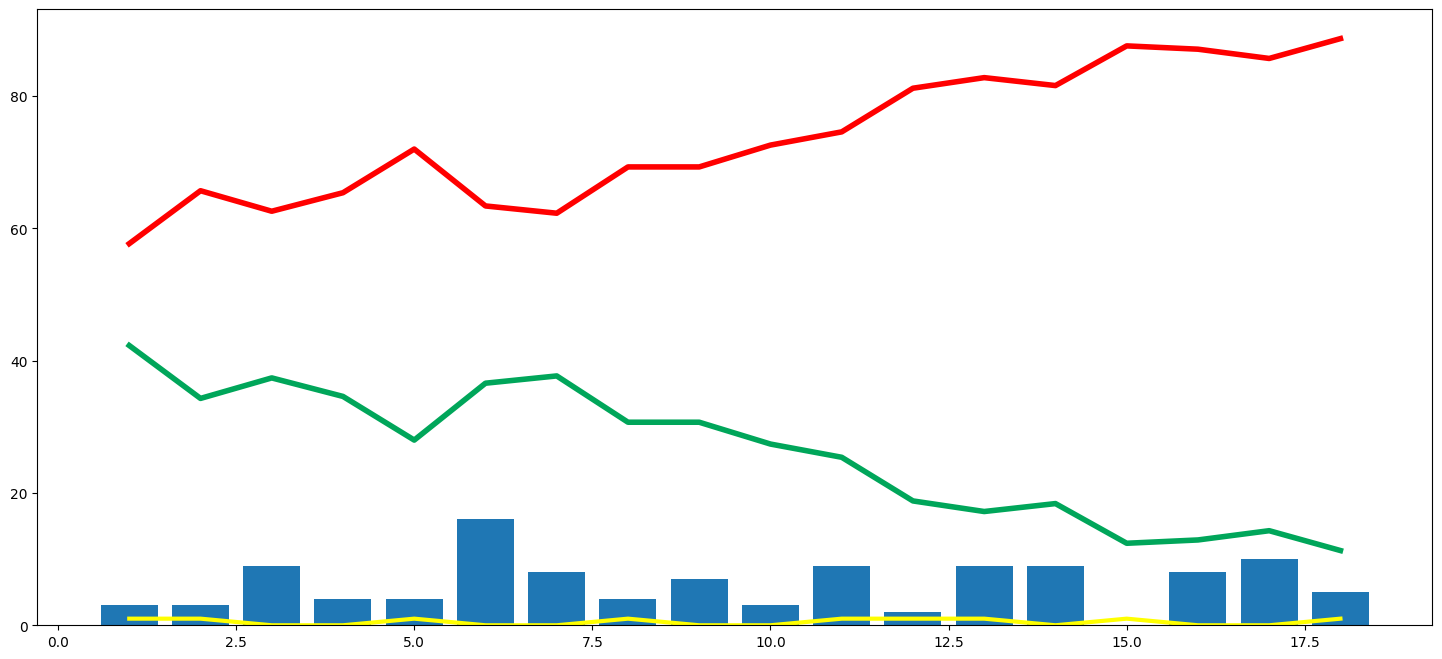

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
# plt.title('Target-' + str(target))

In [40]:
delivery_df['city'].unique()

array(['Bangalore', 'Chandigarh', 'Delhi', 'Mumbai', 'Kolkata', 'Jaipur',
       'Hyderabad', 'Chennai', 'Cape Town', 'Port Elizabeth', 'Durban',
       'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi', nan,
       'Bengaluru', 'Indore', 'Dubai', 'Sharjah', 'Navi Mumbai',
       'Lucknow', 'Guwahati', 'Mohali'], dtype=object)

In [41]:
teams

['Mumbai Indians',
 'Kolkata Knight Riders',
 'Rajasthan Royals',
 'Chennai Super Kings',
 'Sunrisers Hyderabad',
 'Delhi Capitals',
 'Punjab Kings',
 'Lucknow Super Giants',
 'Gujarat Titans',
 'Royal Challengers Bengaluru']

In [42]:
import pickle
pickle.dump(pipe,open('1st_pipe.pkl','wb'))